In [26]:
import numpy as np
import wikipedia_preprocessing as wiki
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from os import path
import re
from matplotlib import pyplot as plt

DATA_folder = path.join("Data", "Wikipedia")

In [2]:
wiki.get_all_dumps()
wiki.precompute_pages(max_dumps=1)

pages = wiki.Pages()

File  exists: aborting download (use force=True to download anyway).
Pages already precomputed: aborting (use force=True).


In [3]:
reg_category = re.compile("^\s*Category:.*\s*$")
reg_redirect = re.compile("REDIRECT")

def get_categories(page):
    categories = []
    for line in page["content"].split("\n"):
        if reg_redirect.match(line):
            return []
        if reg_category.match(line):
            categories.append(line.strip())
    return categories


In [4]:
def all_categories(pages):
    categories = {}
    i = 0
    for p in pages:
        print("\r%s articles computed" % i, end="")
        i += 1
        page_cat = get_categories(p)
        for cat in page_cat:
            if cat in categories:
                categories[cat].append(p["name"])
            else:
                categories[cat] = [p["name"]]
    remove = [cat for cat, l in categories.items() if len(l) < 2]
    for cat in remove:
        del categories[cat]
    print("\nRemoved %d categories with 1 article" % len(remove))
    return categories

In [5]:
cats = all_categories(pages)

19821 articles computed
Removed 43798 categories with 1 article


In [6]:
len(cats)

18080

In [7]:
goodcat = [cat for cat, l in cats.items() if len(l) > 50]

In [8]:
len(goodcat)

34

In [188]:
def get_connected_articles(cats, goodcats):
    articles = set()
    for cat in goodcats:
        for art in cats[cat]:
            articles.add(art)
    return list(articles)

def reorder_names(names):
    pages = wiki.Pages()
    new_names = []
    for p in pages:
        if p["name"] in names:
            new_names.append(p["name"])
    return new_names

    
names=reorder_names(get_connected_articles(cats, goodcat))
len(names)

2480

In [136]:
def create_cat_matrix(goodcats, names):
    Ncorp = len(names)
    cat_matrix = np.zeros((Ncorp, Ncorp))
    for cat in goodcats:
        for i in range(len(cats[cat])):
            for j in range(1, i):
                x = names.index(cats[cat][i])
                y = names.index(cats[cat][j])
                cat_matrix[x, y] = cat_matrix[y, x] = 1
    return cat_matrix

cat_matrix = create_cat_matrix(goodcat, names)

In [10]:
Nvec = 300
word2vec = wiki.get_word2vec()

Loading Word2vec model.
Loaded from pickle


In [11]:
filepath = path.join(DATA_folder, "precomp", "pages_vectorize_cats.vec.gz")
pages = wiki.Pages()
wiki.vectorize_pages_filtered(pages, word2vec, names, filepath)

Pages vectors already computed: aborting.


In [12]:
goodcat

['Category:Articles containing video clips',
 'Category:RTT',
 'Category:American people of English descent',
 'Category:20th-century American novelists',
 'Category:American science fiction writers',
 'Category:Living people',
 'Category:Members of the United States National Academy of Sciences',
 'Category:Republics',
 'Category:Member states of the United Nations',
 'Category:Fellows of the American Academy of Arts and Sciences',
 'Category:Rock and Roll Hall of Fame inductees',
 'Category:American male novelists',
 'Category:Chemical elements',
 'Category:20th-century American male writers',
 'Category:American male non-fiction writers',
 'Category:English-speaking countries and territories',
 'Category:Guggenheim Fellows',
 'Category:Days of the year',
 'Category:American inventions',
 'Category:Fellows of the Royal Society',
 'Category:Christian terminology',
 'Category:Year of birth unknown',
 'Category:American people of Irish descent',
 'Category:20th-century American male act

In [92]:
graph_filepath = path.join(DATA_folder, "precomp", "categories.dot")
def save_dot_file(names, cats, goodcats, filename):
    with open(filename, "w") as f:
        f.write("graph graphname {")
        f.write("node [shape=point, fontsize=0]")
        for c in goodcats:
            for i, a in enumerate(cats[c]):
                for j in range(i + 1, len(cats[c])):
                    x = names.index(cats[c][i])
                    y = names.index(cats[c][j])
                    if x < 200 and y < 200:
                        f.write("a%d -- a%d;" % (x, y))
        f.write("}")

save_dot_file(names, cats, goodcat, graph_filepath)

In [14]:
word2vec

In [15]:
word2vec.vocab.get("hello").index

13169

In [273]:
sim_matrix_path = path.join(DATA_folder, "precomp", "sim1_matrix_%d.pkl")

with open(sim_matrix_path % 100, "rb") as f:
    sim_matrix = pickle.load(f)

In [193]:
sim_graph_filepath = path.join(DATA_folder, "precomp", "similarity.dot")
def sim_save_dot_file(matrix, threshold, filename):
    with open(filename, "w") as f:
        N = len(matrix)
        f.write("graph graphname {")
        f.write("node [shape=point, fontsize=0]")
        for i in range(N):
            for j in range(i + 1, N):
                if matrix[i, j] > threshold:
                    f.write("a%d -- a%d;" % (i, j))
        f.write("}")

sim_save_dot_file(sim_matrix, 40, sim_graph_filepath)

In [275]:
def search_similar(name, sim_matrix, names, N=10):
    matches = np.argsort(-sim_matrix[names.index(name), :])
    return [names[matches[i]] for i in range(N)]

print(names.index('Albert Einstein'))
print(search_similar('Albert Einstein', sim_matrix, names, N=10))

12
['Atom', 'Algeria', 'Albertus Magnus', 'Andorra', 'Accordion', 'April 13', 'August 1', 'Albania', 'April 15', 'Atomic orbital']


In [276]:
print(names.index('Apollo 11'))
print(search_similar('Apollo 11', sim_matrix, names, N=10))

8
['Apollo program', 'Accordion', 'Alkali metal', 'Abscess', 'Americium', 'Atlantic Ocean', 'Atom', 'Aluminium', 'Argon', 'Andorra']


In [195]:
vec_doc_filepath = path.join(DATA_folder, "vec_doc.pkl")

if path.isfile(vec_doc_filepath):
    with open(vec_doc_filepath, "rb") as f:
        doc_vectors = pickle.load(f)
    print("Loaded doc vectors")

Loaded doc vectors


In [135]:
def get_words(name, names, doc_vectors, N=10):
    return [word2vec.similar_by_vector(doc_vectors[names.index(name), i, :Nvec])[0] for i in range(N)]
    
get_words('Albert Einstein', names, doc_vectors, N=10)

[('jeder', 0.9999999403953552),
 ('ArXiv', 1.0000003576278687),
 ('Betrachtungen', 1.0000001192092896),
 ('hf', 1.000000238418579),
 ('pointlike', 1.0000003576278687),
 ('Ostende', 0.9999996423721313),
 ('covariant', 1.0),
 ('1,427', 1.0000003576278687),
 ('stepdaughters', 1.0),
 ('Plumbers', 0.9999998211860657)]

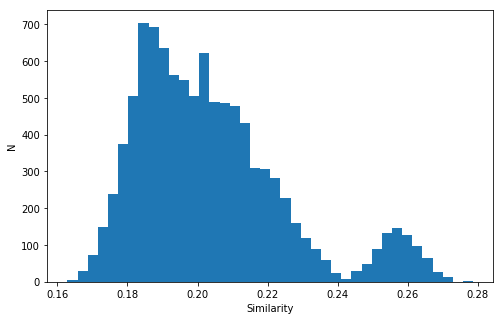

In [274]:
plt.figure(figsize=(8, 5))
plt.hist(sim_matrix[sim_matrix != 0].reshape((-1, 1)), 40)
plt.xlabel("Similarity")
plt.ylabel("N")
plt.savefig(path.join(DATA_folder, "img", "hist1_%d.png" % len(sim_matrix)))
plt.show()

In [249]:
sim_matrix[sim_matrix == 0] = np.min(sim_matrix[sim_matrix != 0])
sim_matrix

array([[0.16284633, 0.18562966, 0.19484973, ..., 0.19360798, 0.1761948 ,
        0.17370621],
       [0.18562966, 0.16284633, 0.19758607, ..., 0.19436163, 0.19571199,
        0.19843324],
       [0.19484973, 0.19758607, 0.16284633, ..., 0.18823476, 0.19396306,
        0.19244777],
       ...,
       [0.19360798, 0.19436163, 0.18823476, ..., 0.16284633, 0.21722178,
        0.21331617],
       [0.1761948 , 0.19571199, 0.19396306, ..., 0.21722178, 0.16284633,
        0.23760624],
       [0.17370621, 0.19843324, 0.19244777, ..., 0.21331617, 0.23760624,
        0.16284633]])

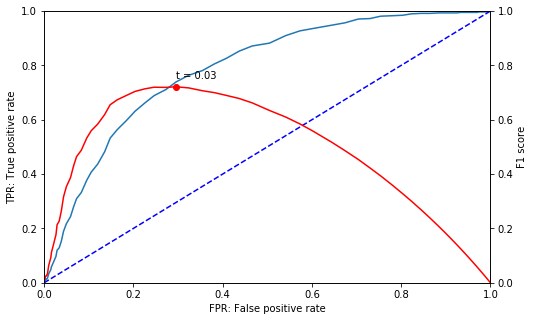

In [265]:
def true_pos_rate(ref_matrix, sim_matrix, threshold):
    return np.sum(ref_matrix[sim_matrix > threshold]) / np.sum(ref_matrix)

def false_pos_rate(ref_matrix, sim_matrix, threshold):
    return np.sum(1 - ref_matrix[sim_matrix > threshold]) / np.sum(1 - ref_matrix)

def RoC_curve(ref_matrix, sim_matrix, thresholds):
    true_pos_rates = np.zeros(len(thresholds))
    false_pos_rates = np.zeros(len(thresholds))
    for i, t in enumerate(thresholds):
        true_pos_rates[i] = true_pos_rate(ref_matrix, sim_matrix, t)
        false_pos_rates[i] = false_pos_rate(ref_matrix, sim_matrix, t)
    return true_pos_rates, false_pos_rates


def plot_curve(ref_matrix, sim_matrix, a, b, n=20, filename=None):
    thresholds = np.arange(a, b, (b - a)/n)
    true_pos_rates, false_pos_rates = RoC_curve(ref_matrix, sim_matrix, thresholds)
    f1 = 2 * true_pos_rates * (1 - false_pos_rates) / (true_pos_rates + 1 - false_pos_rates)
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    ax1.plot(false_pos_rates, true_pos_rates)
    ax2.plot(false_pos_rates, f1, "r")
    ax1.plot([0, 1], [0, 1], "b--")
    ax2.plot(false_pos_rates[np.argmax(f1)], np.max(f1), "ro")
    ax2.annotate("t = %.2f" % thresholds[np.argmax(f1)], (false_pos_rates[np.argmax(f1)], np.max(f1) + 0.03))
    ax1.set_xlabel("FPR: False positive rate")
    ax1.set_ylabel("TPR: True positive rate")
    ax2.set_ylabel("F1 score")
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax2.set_ylim([0, 1])
    if filename:
        plt.savefig(filename)
    else:
        plt.show()
    
    
Nmat = len(sim_matrix)
ref_matrix = cat_matrix[:Nmat, :Nmat]
a, b = -0.10, 0.15
plot_curve(ref_matrix, sim_matrix, a, b, n=100, filename=path.join(DATA_folder, "img", "ROC1_small_%d.png" % len(sim_matrix)))

## 